# Aujourd'hui on roule sur les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html

# Imports des librairies de bases

On ajoutera celles qui manquent au fur et à mesure de nos besoins

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os, gc

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [2]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

# Définition des paramètres pour Matplot

Rien de bien intéréssant

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set des variables globales

Attention, je n'utilise les variables globales pour la gestion des fichiers. Sinon, c'est mort

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = ".."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

# Fonction pour load les libraires

En vrai, on a juste besoin de pd.read_csv, mais c'était pour faire joli

In [5]:
def load_data(file,data_path=DATA_PROCESSED, sep=';'):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep=';')

# On load les jeux de données

In [6]:
TX_data = load_data(file = "train.csv");
TEST_DATA = load_data(file = "test.csv");

In [7]:
TEST_DATA.head()

,ID,SHIPPING_MODE,SHIPPING_PRICE,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,PRICECLUB_STATUS,REGISTRATION_DATE,PURCHASE_COUNT,...,SELLER_DEPARTMENT_PIB,CAC_POINTS,CAC_VAR,IS_HOLIDAYS,IS_SALES,Mean_Claims_Sells_ID,STD_Claims_Sells_ID,Count_PRODUCT_TYPE,Mean_Claims_PRODUCT_TYPE,STD_Claims_PRODUCT_TYPE
0,100000,RECOMMANDE,0,1,0,1,0,4,2012,3,...,21489,5329,5,0,0,0.558935,0.496751,342.0,0.637427,0.481447
1,100001,RECOMMANDE,0,1,0,0,0,0,2012,0,...,23982,5283,0,0,0,0.682482,0.466363,1383.0,0.571222,0.495080
2,100002,MONDIAL_RELAY,2,1,0,0,0,0,2017,0,...,34257,5329,5,0,0,0.756757,0.429871,21987.0,0.392505,0.488319
3,100003,NORMAL,0,1,0,0,0,4,2011,3,...,-99999,5120,-3,0,1,0.346306,0.475826,21987.0,0.392505,0.488319
4,100004,RECOMMANDE,0,1,0,0,0,0,2006,0,...,-99999,5093,-1,1,1,0.794521,0.406848,6349.0,0.687667,0.463481


In [8]:
TX_data.drop(['CARD_PAYMENT','COUPON_PAYMENT','RSP_PAYMENT','WALLET_PAYMENT'], axis = 1, inplace = True)
TEST_DATA.drop(['CARD_PAYMENT','COUPON_PAYMENT','RSP_PAYMENT','WALLET_PAYMENT'], axis = 1, inplace = True)

In [9]:
TX_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 30 columns):
SHIPPING_MODE                100000 non-null object
SHIPPING_PRICE               100000 non-null int64
PRICECLUB_STATUS             100000 non-null int64
REGISTRATION_DATE            100000 non-null int64
PURCHASE_COUNT               100000 non-null int64
BUYER_BIRTHDAY_DATE          100000 non-null float64
BUYING_DATE                  100000 non-null int64
SELLER_SCORE_COUNT           100000 non-null int64
SELLER_SCORE_AVERAGE         100000 non-null float64
SELLER_COUNTRY               100000 non-null object
PRODUCT_TYPE                 100000 non-null object
PRODUCT_FAMILY               100000 non-null object
ITEM_PRICE                   100000 non-null int64
CLAIM_TYPE                   100000 non-null object
WARRANTY_COV_RATE            100000 non-null float64
SELLER_COUNTRY_PIB           100000 non-null int64
SELLER_COUNTRY_DISTANCE      100000 non-null int64
BUYER_DEPART

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.3, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["CLAIM_TYPE"]
                                      )
del TX_data;

# Jointure entre les X et Y

In [11]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    try :
        Y=data["CLAIM_TYPE"]
        X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    except:
        Y=0
        X=data
    # Exclude Objets
    X=X.select_dtypes(exclude=['object'])
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [12]:
X_train, Y_train = datapreprocess(train_set)
X_test, Y_test = datapreprocess(test_set)
TEST_DATA, _ = datapreprocess(TEST_DATA)

#del TX_data;
gc.collect()

360

In [13]:
def multiclass_roc_auc_score(truth, pred):
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [14]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

# MODEL!

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [15]:
from sklearn.model_selection import GridSearchCV

In [26]:
from sklearn.utils.class_weight import compute_sample_weight

In [27]:
sample_weight_arr = compute_sample_weight(class_weight='balanced', y=Y_train)
sample_weight_dict = {'sample_weight':compute_sample_weight(class_weight='balanced', y=Y_train)}

## XGBoost

In [28]:
from xgboost import XGBClassifier

###  XGBoost solo

In [29]:
params_XGB={
            'colsample_bytree' : 0.85,
            'eval_metric':"merror",
            'gamma' : 0.4,
            'learning_rate' : 0.1,
            'max_depth' : 3,
            'min_child_weight' : 5,
            'n_estimators' : 1000,
            'nthread' : 4,
            'objective' : 'multi:softmax',
            'reg_alpha' : 0.005,
            'scale_pos_weight' : 1,
            'seed' : RANDOM_SEED,
            'subsample' : 0.55,
            'scale_pos_weight' : sample_weight_arr
}

In [30]:
xgb_clf = XGBClassifier(**params_XGB)

In [31]:
xgb_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, eval_metric='merror', gamma=0.4,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0.005, reg_lambda=1,
       scale_pos_weight=array([ 0.84411,  0.84411, ...,  0.25011,  0.25011]),
       seed=42, silent=True, subsample=0.55)

In [32]:
y_pred_xgb_train = xgb_clf.predict(X_train)
y_pred_xgb = xgb_clf.predict(X_test)

In [33]:
train_mAUC = multiclass_roc_auc_score(Y_train, y_pred_xgb_train)
test_mAUC = multiclass_roc_auc_score(Y_test, y_pred_xgb)

In [34]:
print("Performance sur le train : {}".format(train_mAUC))
print("Performance sur le test : {}".format(test_mAUC))
print("Ratio entre les deux : {} ".format(test_mAUC/train_mAUC))

Performance sur le train : 0.6096319605158903
Performance sur le test : 0.5883152323687212
Ratio entre les deux : 0.965033447181591 


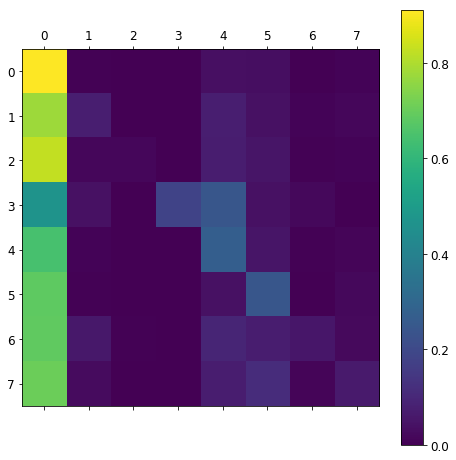

In [35]:
conf_mx = confusion_matrix(Y_test, y_pred_xgb)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

### XGBoost Grid Search

In [38]:
params = {#'learning_rate':[0.3, 0.2, 0.1, 0.05, 0.01],
          'max_depth':list(range(3,6)),
          'subsample': [0.5, 0.6, 0.7],
          'colsample_bytree':[0.5, 0.6, 0.7]
         }

In [39]:
xgb_gs_cv = GridSearchCV(XGBClassifier(eval_metric ="merror", 
                                       learning_rate=0.1,
                                       seed =RANDOM_SEED,
                                       scale_pos_weight=sample_weight_arr), 
                              params,
                               
                              n_jobs=-1,
                              verbose=1)

In [40]:
xgb_gs_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 34.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='merror', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1,
       scale_pos_weight=array([ 0.84411,  0.84411, ...,  0.25011,  0.25011]),
       seed=42, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5], 'subsample': [0.5, 0.6, 0.7], 'colsample_bytree': [0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [41]:
xgb_gs_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='merror', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1,
       scale_pos_weight=array([ 0.84411,  0.84411, ...,  0.25011,  0.25011]),
       seed=42, silent=True, subsample=0.7)

In [42]:
y_pred_xgb_cv = xgb_gs_cv.predict(X_test)

In [43]:
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, y_pred_xgb_cv)))

ROC score : 0.5790124946982369


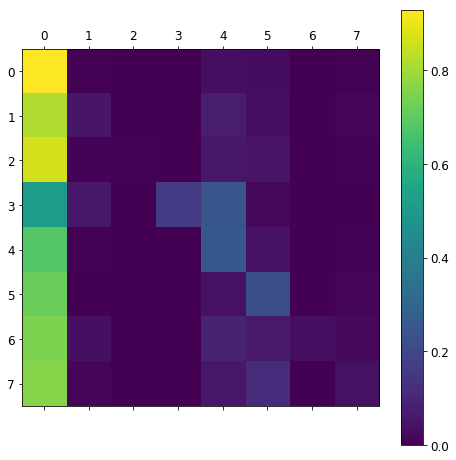

In [45]:
conf_mx = confusion_matrix(Y_test, y_pred_xgb_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

## Summary

In [ ]:
#RESULTS["CLAIM_TYPE"] = pd.DataFrame(clf.predict(TEST_DATA), columns=["Result"])

In [ ]:
#filename = DATA_PROCESSED+"/submission_2.csv"

#RESULTS.to_csv(filename, index=False, sep=";")